欢迎来到30分钟的 Flower 联邦学习教程！

在这个教程中，您将使用 [Flower](https://flower.dev/) 实现您的第一个联邦学习项目。

🧑‍🏫 这个是一个从零开始的教程，不需要您熟悉联邦学习。只假设您具有基础的数据科学和Python编程知识。本教材并不要求有最基础的机器学习知识，但如果您已经知道相关内容，没有什么能阻止您按照自己的需求修改这些代码！

> 在 [GitHub ⭐️](https://github.com/adap/flower) 上收藏 Flower，并加入 Flower 在 Slack 的社群来建立联系，提问，和获得帮助：[加入Slack 🌼](https://flower.dev/join-slack/)。我们非常希望在 #introductions 频道听到您的声音！如果有任何不清晰的地方，欢迎前往 #questions 频道进行提问。

> 欢迎关注我们的**bilibili账号** [Flower联邦学习框架](https://space.bilibili.com/3546373735582167)！

让我们开始吧！


## 补充内容

但在开始之前，推荐您观看[Flower Youtube频道](https://www.youtube.com/@flowerlabs)上的一些英文视频教程，您可能会在本教程之后想要查看。我们会相对规律地发布新的内容：
* **[视频]** quickstart-tensorflow: [关于如何开始使用Flower + Tensorflow/Keras的15分钟视频](https://www.youtube.com/watch?v=jOmmuzMIQ4c)
* **[视频]** quickstart-pytorch: [关于如何开始使用Flower + PyTorch的20分钟视频](https://www.youtube.com/watch?v=jOmmuzMIQ4c)
* **[视频]** Flower仿真-迷你系列: [9个逐行视频教程](https://www.youtube.com/watch?v=cRebUIGB5RU&list=PLNG4feLHqCWlnj8a_E1A_n5zr2-8pafTB)


# 环境设置

现在让我们真正开始这个教程！

要开始使用Flower，一旦您激活了您的Python环境（例如通过`conda`、`virtualenv`、`pyenv`等），所需的准备工作非常少。如果您在Colab上运行这段代码，实际上没有什么需要做的，只需安装Flower和其他依赖项。下面的步骤已在Colab中进行了验证。首先，让我们安装Flower，然后选择您想要使用的机器学习框架和其他可能需要的额外依赖项。

## 安装Flower

您可以非常方便地从`pip`安装Flower：


In [6]:
# depending on your shell, you might need to add `\` before `[` and `]`.
pip install -q flwr[simulation]

SyntaxError: invalid syntax (1596128392.py, line 2)

我们将使用Flower中的 _仿真_ 模型，该模型允许您在不手动管理设备的额外负担下运行大量的客户端。这是通过`虚拟客户端引擎`(Virtual Client Engine)实现的，这是运行[FL仿真](https://flower.dev/docs/framework/how-to-run-simulations.html)的Flower的核心组件。使用仿真，无论您是在笔记本电脑上运行代码，还是在拥有单个GPU的机器、多个GPU的服务器，甚至是多个服务器的集群上运行，您都可以动态地扩展实验。`虚拟客户端引擎`透明地处理一切，并且允许您指定应分配给每个虚拟客户端多少资源（例如，CPU核心，GPU VRAM）。


## 安装您的机器学习框架

Flower支持任何机器学习框架。Flower支持`PyTorch`、`Tensorflow`、`NumPy`、`🤗 Transformers`、`MXNet`、`JAX`、`scikit-learn`、`fastai`、`Pandas`。Flower还支持所有主要平台：`iOS`、`Android`和纯`C++`。您可以在[Flower仓库](https://github.com/adap/flower/tree/main/examples)的`examples/`目录中找到以上每个框架的 *quickstart-example* 并查阅[Flower文档](https://flower.dev/docs/)以获取更多学习材料。

在本教程中，我们将使用PyTorch，因此让我们安装一个最新版本。在这个教程中，我们将使用一个小型模型，因此仅使用CPU进行训练就足够了（这也将防止Colab因超出资源限制而突然终止您的实验）。


In [5]:
# you might see a warning after running the command below, this can be ignored
# if you are running this outside Colab, you probably need to adjust the command below
pip install torch==1.13.1+cpu torchvision==0.14.1+cpu torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cpu

SyntaxError: invalid syntax (1168649690.py, line 3)

我们将安装一些您可能熟悉的其他依赖项。我们将使用这些依赖项进行绘图。

In [4]:
pip install matplotlib

# 集中式训练：传统的机器学习方式

首先，让我们创建一个简单（但完整）的训练循环，这在集中式设置中是常见的。以这种方式开始我们的教程将使我们能够非常清晰地识别典型的机器学习流程中哪些部分是集中式和联邦训练共有的，以及哪些部分是截然不同的。

对于本教程，我们将设计一个用于[MNIST数字](https://en.wikipedia.org/wiki/MNIST_database)的图像分类流程，并使用一个简单的CNN模型作为要训练的网络。MNIST数据集由`28x28`的灰度图像组成，其中包含从0到9的数字（即总共有10个类别）。

## 数据集

让我们从构建数据集开始。

In [8]:
# we naturally first need to import torch and torchvision
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST


def get_mnist(data_path: str = './data'):
    '''This function downloads the MNIST dataset into the `data_path`
    directory if it is not there already. WE construct the train/test
    split by converting the images into tensors and normalising them'''

    # transformation to convert images to tensors and apply normalisation
    tr = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

    # prepare train and test set
    trainset = MNIST(data_path, train=True, download=True, transform=tr)
    testset = MNIST(data_path, train=False, download=True, transform=tr)

    return trainset, testset

运行上面的代码，并进行一些可视化，以更好地了解我们正在处理的数据！

In [10]:
trainset, testset = get_mnist()

直接键入变量名，我们可以快速预览我们的数据集。例如，下面您可以看到`trainset`有6万个训练样本，并将使用我们在`get_mnist()`中定义的转换规则。

In [12]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

让我们创建一个信息密度更高的可视化。首先，通过构建一个直方图来查看标签的分布情况。然后，让我们可视化一些训练样本！

Text(0.5, 1.0, 'Class labels distribution for MNIST')

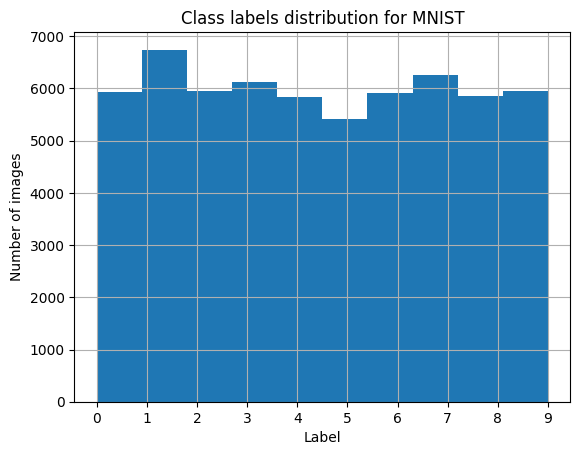

In [24]:
import matplotlib.pyplot as plt


# construct histogram
all_labels = trainset.targets
num_possible_labels = len(set(all_labels.numpy().tolist())) # this counts unique labels (so it should be = 10)
plt.hist(all_labels, bins=num_possible_labels)

# plot formatting
plt.xticks(range(num_possible_labels))
plt.grid()
plt.xlabel('Label')
plt.ylabel('Number of images')
plt.title('Class labels distribution for MNIST')

让我们从数据集中可视化32张图像

In [14]:
import random
import numpy as np

def visualise_n_random_examples(trainset_, n: int, verbose: bool = True):
  # take n examples at random
  idx =list(range(len(trainset_.data)))
  random.shuffle(idx)
  idx = idx[:n]
  if verbose:
    print(f"will display images with idx: {idx}")


  # construct canvas
  num_cols = 8
  num_rows = int(np.ceil(len(idx)/num_cols))
  fig, axs = plt.subplots(figsize=(16, num_rows*2), nrows=num_rows, ncols=num_cols)

  # display images on canvas
  for c_i, i in enumerate(idx):
    axs.flat[c_i].imshow(trainset_.data[i], cmap='gray')

will display images with idx: [56718, 10999, 1887, 42482, 4407, 8970, 14497, 31479, 8945, 56171, 4043, 53649, 18604, 27728, 52419, 42982, 52310, 30489, 18929, 14599, 18764, 33634, 10296, 15093, 17813, 15556, 19330, 25609, 49922, 131, 41145, 26780]


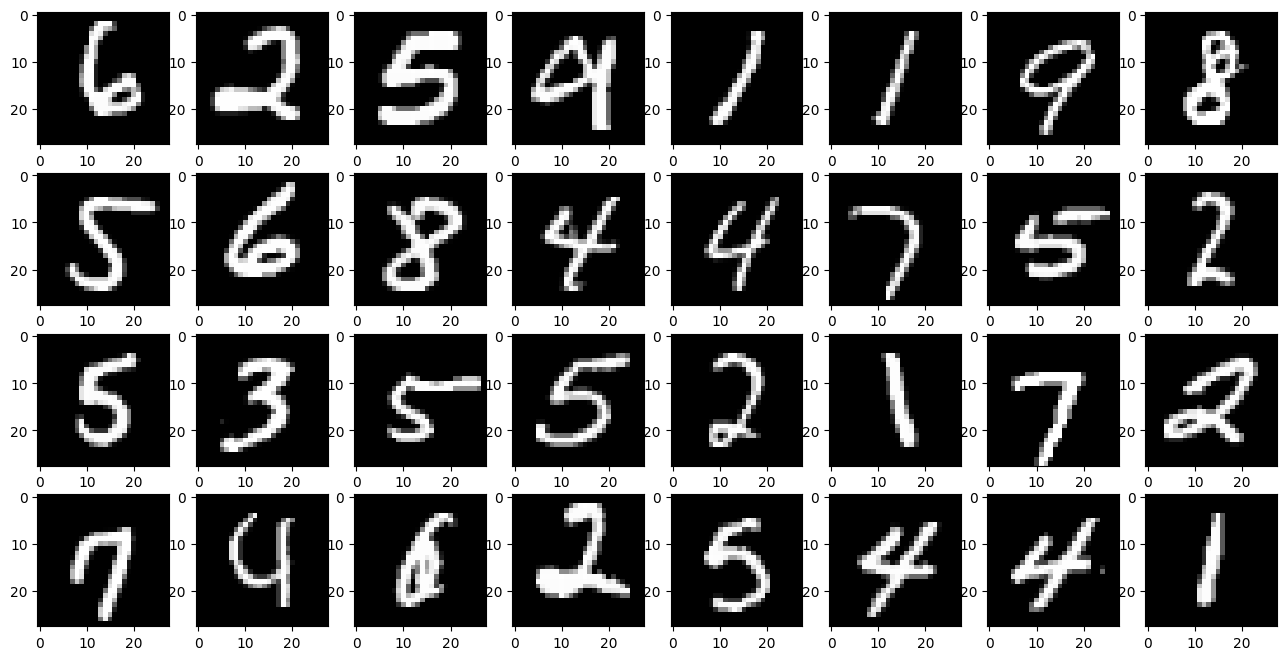

In [15]:
# it is likely that the plot this function will generate looks familiar to other plots you might have generated before
# or you might have encountered in other tutorials. So far, we aren't doing anything new, Federated Learning will start soon!
visualise_n_random_examples(trainset, n=32)

# CNN架构

这个教程并不主要关注新颖的架构设计，因此我们用一个很简单的、适用于MNIST图像分类任务的典型CNN。

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


您也可以通过多种方式查看模型。例如，我们可以统计模型参数的数量。


In [17]:
model = Net(num_classes=10)
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 44426


## 训练循环

在PyTorch中，一个最简单的训练循环可以用三个函数构建：
* `train()` 将使用给定的数据加载器来训练模型。
* `test()` 将用于评估模型在保留数据(held-out data)上的性能，例如，一个训练集。
* `run_centralised()` 将定义额外的元素（例如优化器）并在N个周期上运行训练循环。

让我们构建这些函数！


In [20]:
def train(net, trainloader, optimizer, epochs):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for _ in range(epochs):
        for images, labels in trainloader:
            optimizer.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
    return net

def test(net, testloader):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy


def run_centralised(epochs: int, lr: float, momentum: float=0.9):
    """A minimal (but complete) training loop"""

    # instantiate the model
    model = Net(num_classes=10)

    # define optimiser with hyperparameters supplied
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # get dataset and construct a dataloaders
    trainset, testset = get_mnist()
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=128)

    # train for the specified number of epochs
    trained_model = train(model, trainloader, optim, epochs)

    # training is completed, then evaluate model on the test set
    loss, accuracy = test(trained_model, testloader)
    print(f"{loss = }")
    print(f"{accuracy = }")

让我们运行这个程序5个周期（您会看到它接近99%的准确率——这是从使用MNIST数据集的集中式设置中预期的结果）。


In [21]:
run_centralised(epochs=5, lr=0.01)

loss = 3.3287365073920228
accuracy = 0.987


上面的集中式方案对于某些应用和场景中的来说非常有效。然而，正如本次教程早些时候所讨论的，集中式训练不适用于更多的复杂场景，因为无法收集信息以构建统一（集中式）的数据集。

# AI的未来是联邦学习

联邦学习和集中式训练之间的主要区别是什么？如果您只能选择一个，您可能会说：
* 联邦学习是分布式的——模型是由参与的客户端在设备上进行训练的。
* 数据保持私密并由特定的*客户端* 拥有——数据从未发送到中央服务器。

还有更多的区别。但上面的两点是始终需要考虑的主要区别，并且适用于所有类型的联邦学习（例如，*跨设备* 或*跨机构*, Cross-device or Cross-silo）。本教程接下来的部分将集中于将我们目前集中式设置的代码转化为使用Flower和PyTorch构建的联邦学习流程。

让我们开始吧！🚀


## 一个客户端，一个数据分区

为了开始设计一个联邦学习（Federated Learning，简称FL）流程，我们需要满足FL的一个关键特性：每个客户端都有其自己的数据分区。为了用MNIST数据集实现这一点，我们将生成N个随机分区，其中N是我们FL系统中客户端的总数。


In [22]:
from torch.utils.data import random_split

def prepare_dataset(num_partitions: int,
                    batch_size: int,
                    val_ratio: float = 0.1):

    """This function partitions the training set into N disjoint
    subsets, each will become the local dataset of a client. This
    function also subsequently partitions each traininset partition
    into train and validation. The test set is left intact and will
    be used by the central server to asses the performance of the
    global model. """

    # get the MNIST dataset
    trainset, testset = get_mnist()

    # split trainset into `num_partitions` trainsets
    num_images = len(trainset) // num_partitions

    partition_len = [num_images] * num_partitions

    trainsets = random_split(trainset, partition_len, torch.Generator().manual_seed(2023))

    # create dataloaders with train+val support
    trainloaders = []
    valloaders = []
    for trainset_ in trainsets:
        num_total = len(trainset_)
        num_val = int(val_ratio * num_total)
        num_train = num_total - num_val

        for_train, for_val = random_split(trainset_, [num_train, num_val], torch.Generator().manual_seed(2023))

        trainloaders.append(DataLoader(for_train, batch_size=batch_size, shuffle=True, num_workers=2))
        valloaders.append(DataLoader(for_val, batch_size=batch_size, shuffle=False, num_workers=2))

    # create dataloader for the test set
    testloader = DataLoader(testset, batch_size=128)

    return trainloaders, valloaders, testloader

让我们创建100个分区，并从其中一个分区提取一些统计信息。


number of images: 540


Text(0.5, 1.0, 'Class labels distribution for MNIST')

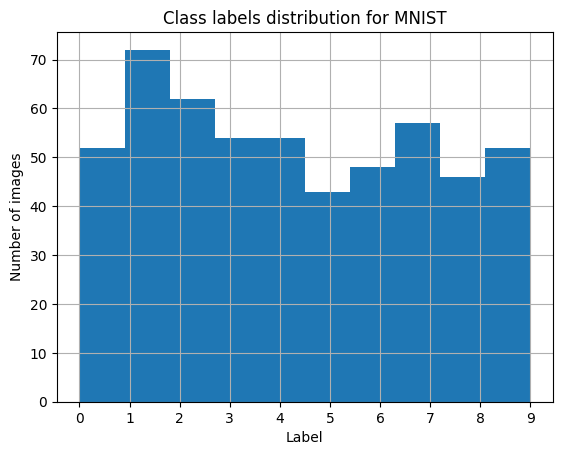

In [25]:
trainloaders, valloaders, testloader = prepare_dataset(num_partitions=100,
                                                       batch_size=32)

# first partition
train_partition = trainloaders[0].dataset

# count data points
partition_indices = train_partition.indices
print(f"number of images: {len(partition_indices)}")

# visualise histogram
plt.hist(train_partition.dataset.dataset.targets[partition_indices], bins=10)
plt.grid()
plt.xticks(range(10))
plt.xlabel('Label')
plt.ylabel('Number of images')
plt.title('Class labels distribution for MNIST')

如您所见，这个分区的直方图与我们一开始考虑整个数据集时获得的直方图略有不同。由于我们的数据分区是通过以独立同分布（IID）的方式对MNIST数据集进行采样来人为构造的，因此我们的联邦学习示例不会面临严重的*数据异质性* 问题（这是一个相当[活跃的研究课题](https://arxiv.org/abs/1912.04977)）。

接下来让我们定义我们的FL客户端将如何表现。

## 定义一个Flower客户端

您可以将FL中的客户端视为拥有一些数据并使用这些数据训练模型的实体。问题是，该模型是由多个客户端（有时多达数十万个）*协作* 进行训练的。并且在FL的大多数实例中，模型是由中央服务器发送的。

Flower客户端是一个具有四个不同方法的简单Python类：

* `fit()`：通过此方法，客户端使用其自己的数据进行设备上的训练若干周期（epoch）。最后，产生的模型会发送回服务器进行聚合。

* `evaluate()`：通过此方法，服务器可以评估全局模型在客户端的本地验证集上的性能。这可以用于例如当服务器上没有用于验证/测试的集中式数据集时。此外，此方法还可以用于评估正在联合的模型的个性化程度。

* `set_parameters()`：此方法接受服务器发送的参数，并使用它们来初始化特定于ML框架的本地模型（例如，TF、Pytorch等）。

* `get_parameters()`：它从本地模型中提取参数，并将它们转换成一组NumPy数组。这种与ML框架无关的模型表示将被发送到服务器。

让我们从 import flwr 开始！


In [ ]:
import flwr as fl

现在定义一下我们的Flower客户端类：

In [ ]:
from collections import OrderedDict
from typing import Dict, Tuple

import torch
from flwr.common import NDArrays, Scalar

class FlowerClient(fl.client.NumPyClient):
    def __init__(self,
                 trainloader,
                 vallodaer) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = vallodaer
        self.model = Net(num_classes=10)

    def set_parameters(self, parameters):
        """With the model parameters received from the server,
        overwrite the uninitialise model in this class with them."""

        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        # now replace the parameters
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        """Extract all model parameters and convert them to a list of
        NumPy arrays. The server doesn't work with PyTorch/TF/etc."""
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """This method train the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""

        # copy parameters sent by the server into client's local model
        self.set_parameters(parameters)

        # Define the optimizer -------------------------------------------------------------- Essentially the same as in the centralised example above
        optim = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)

        # do local training  -------------------------------------------------------------- Essentially the same as in the centralised example above (but now using the client's data instead of the whole dataset)
        train(self.model, self.trainloader, optim, epochs=1)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        self.set_parameters(parameters)
        loss, accuracy = test(self.model, self.valloader) # <-------------------------- calls the `test` function, just what we did in the centralised setting (but this time using the client's local validation set)
        # send statistics back to the server
        return float(loss), len(self.valloader), {'accuracy': accuracy}

请花费几分钟时间仔细查看上面的`FlowerClient`类。如果有不清楚的地方，请提问！

你们中观察敏锐的可能已经意识到，如果我们将客户端的 `fit()` 和 `evaluate()` 方法融合在一起，我们将得到与本教程中的集中式训练部分中使用的 `run_centralised()` 函数几乎相同的东西。这是真的！！在联邦学习中，客户端进行本地训练的方式利用了与更传统的集中式设置相同的原理。关键的不同之处在于，现在的数据集要小得多，而且永远不会被运行 FL 工作负载的实体（即中央服务器）“看到”。

说到中央服务器。。。 我们应该定义一下我们希望使用哪种策略，以便客户端在 `fit()` 方法结束时将更新的模型发送回服务器进行聚合。

## 选择 Flower 策略（Strategy）

策略（Strategy）是联邦学习实验的核心。它参与到 FL 管道的所有阶段：抽样客户端；将 _全局模型_ 发送到客户端，以便他们可以执行 `fit()`；从客户端接收更新的模型，并通过**聚合**这些来构建一个新的 _全局模型_ ；定义和执行全局或联邦评估；等等。

Flower 自带了[许多内置的策略](https://github.com/adap/flower/tree/main/src/py/flwr/server/strategy)，在下一个版本中还会有更多。对于本教程，让我们使用可能是最受欢迎的策略之一：`FedAvg`。

`FedAvg` 的工作方式很简单，但在实践中表现出奇地好。因此，它是开始您的实验的一个很好的策略。顾名思义，`FedAvg` 通过取所有参与该轮次的客户端发送的模型的平均值来派生出 _全局模型_ 的新版本。您可以在[论文中](https://arxiv.org/abs/1602.05629)阅读所有详细信息。

让我们看看如何使用 Flower 定义 `FedAvg`。我们使用名为 `evaluate_fn` 的回调之一，以便我们可以使用一个小型的集中式测试集轻松评估全局模型的状态。注意，这个功能是由用户定义的，因为它需要在 ML 框架方面进行选择（如果您回想一下，Flower 是框架不可知的）。

> 也就是说，只有在存在某种程度上遵循分布在各个客户端之间的数据的集中式数据集的情况下，才可能对全局模型进行集中式评估。在某些情况下，没有这样的集中式数据集用于验证是不可能的，因此唯一的解决方案是对 _全局模型_ 进行联邦评估。这是 Flower 中的默认行为。如果您在策略中没有指定 `evaluate_fn` 参数，那么，集中式全局评估将不会被执行。


In [ ]:
def get_evalulate_fn(testloader):
    """This is a function that returns a function. The returned
    function (i.e. `evaluate_fn`) will be executed by the strategy
    at the end of each round to evaluate the stat of the global
    model."""
    def evaluate_fn(server_round: int, parameters, config):
        """This function is executed by the strategy it will instantiate
        a model and replace its parameters with those from the global model.
        The, the model will be evaluate on the test set (recall this is the
        whole MNIST test set)."""

        model = Net(num_classes=10)

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        # call test
        loss, accuracy = test(model, testloader) # <-------------------------- calls the `test` function, just what we did in the centralised setting
        return loss, {"accuracy": accuracy}

    return evaluate_fn


# now we can define the strategy
strategy = fl.server.strategy.FedAvg(fraction_fit=0.1, # let's sample 10% of the client each round to do local training
                                      fraction_evaluate=0.1, # after each round, let's sample 20% of the clients to asses how well the global model is doing
                                      min_available_clients=100, # total number of clients available in the experiment
                                      evaluate_fn=get_evalulate_fn(testloader)) # a callback to a function that the strategy can execute to evaluate the state of the global model on a centralised dataset


到目前为止，我们已经：
* 为每个客户端创建了数据集分区
* 定义了客户端类
* 决定了要使用的策略

现在我们只需要启动 Flower 的 FL（联邦学习）实验了。。。 别急！还有最后一个函数：让我们创建另一个回调，该回调将由 Simulation Engine 使用以生成虚拟客户端（VirtualClients）。正如您所看到的，这非常简单：构造一个 FlowerClient 对象，并为每个对象分配自己的数据分区。


In [ ]:
def generate_client_fn(trainloaders, valloaders):
    def client_fn(cid: str):
        """Returns a FlowerClient containing the cid-th data partition"""

        return FlowerClient(trainloader=trainloaders[int(cid)],
                            vallodaer=valloaders[int(cid)])
    return client_fn

client_fn_callback = generate_client_fn(trainloaders, valloaders)

现在，我们准备好使用 Flower 的仿真来启动 FL（联邦学习）实验了：

In [ ]:
history = fl.simulation.start_simulation(
    client_fn=client_fn_callback, # a callback to construct a client
    num_clients=100, # total number of clients in the experiment
    config=fl.server.ServerConfig(num_rounds=10), # let's run for 10 rounds
    strategy=strategy, # the strategy that will orchestrate the whole FL pipeline
)

INFO flwr 2023-09-27 10:03:06,486 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-09-27 10:03:13,377	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-27 10:03:19,046 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7814224283.0, 'object_store_memory': 3907112140.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7814224283.0, 'object_store_memory': 3907112140.0}
INFO flwr 2023-09-27 10:03:19,058 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-09-27 10:03:19,066 | app.py:224 | Flower VCE: Resources for each Virtual Cl

在仅使用 CPU 的 Colab 实例上进行 10 轮应该不到 2 分钟就能完成 <-- Flower 仿真是非常快的！🚀

然后，您可以使用返回的 `History` 对象将结果保存到磁盘或进行一些可视化（当然，两者也可以同时进行，或者如果您喜欢混乱，也可以都不做）。下面，您可以看到如何绘制每一轮（包括实验一开始）的全局模型的集中精确度。这是我们传递给策略的 `evaluate_fn()` 函数所报告的。


history.metrics_centralized = {'accuracy': [(0, 0.0962), (1, 0.2108), (2, 0.2526), (3, 0.3936), (4, 0.4999), (5, 0.6377), (6, 0.7764), (7, 0.8334), (8, 0.8612), (9, 0.8895), (10, 0.8942)]}


Text(0.5, 1.0, 'MNIST - IID - 100 clients with 10 clients per round')

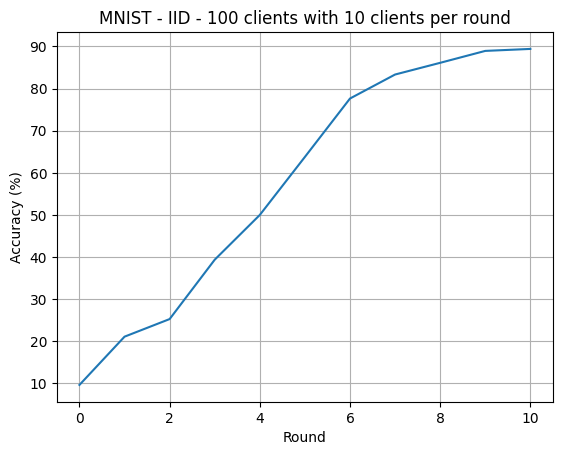

In [ ]:
print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized['accuracy']
round = [data[0] for data in global_accuracy_centralised]
acc = [100.0*data[1] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.grid()
plt.ylabel('Accuracy (%)')
plt.xlabel('Round')
plt.title('MNIST - IID - 100 clients with 10 clients per round')

## 下一步？

嗯，如果您喜欢这个内容，考虑在 GitHub 上收藏我们 ⭐️ -> https://github.com/adap/flower

* **[文档]** 如何在 GPU 上运行您的 Flower 客户端？在 [Flower 仿真文档](https://flower.dev/docs/framework/how-to-run-simulations.html)中查找如何做到这一点。

* **[视频]** 您可以关注我们的[详细逐行的 9-部视频教程](https://www.youtube.com/watch?v=cRebUIGB5RU&list=PLNG4feLHqCWlnj8a_E1A_n5zr2-8pafTB)，了解设计您自己的 Flower 模拟管道所需的一切。

* 在 Flower 的 GitHub 上查看更多高级模拟示例：

    * 使用 Tensorflow/Keras 的 Flower 模拟：[![在 Colab 中打开](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/adap/flower/tree/main/examples/simulation-tensorflow)
    
    * 使用 Pytorch 的 Flower 模拟：[![在 Colab 中打开](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/adap/flower/tree/main/examples/simulation-pytorch)

* **[文档]** 所有 Flower 示例：https://flower.dev/docs/examples/

* **[视频]** 我们的 Youtube 频道：https://www.youtube.com/@flowerlabs
* **[视频]** 我们的**bilibili账号**：[Flower联邦学习框架](https://space.bilibili.com/3546373735582167)

不要忘了加入我们的 Slack 频道：https://flower.dev/join-slack/
